# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [11]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU if use_cuda is True
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)        
        
        # TODO: compute negative log likelihood loss
        loss = F.nll_loss(output, target)
        
        # TODO: do backpropagation
        loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = F.sigmoid(x)

        x = self.fc2(x)
        x = F.sigmoid(x)

        x = self.fc3(x)
        x = F.sigmoid(x)

        x = self.fc4(x)
        x = F.sigmoid(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [5]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with ReLU non-linearity and batch normalization to the first and third layers
    
    Dimensions
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 60)
        self.fc4 = nn.Linear(60, 30)
        self.fc5 = nn.Linear(30, 10)

        self.bn1 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(60)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)

        # TODO: run network layers
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = F.relu(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.fc4(x)
        x = F.relu(x)
        
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [8]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    batch normalization to first convolutional and first fully connected layer
    use max pooling instead of stride to reduce the dimensions to 64x12x12
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers and batch normalization to first convolutional and first fully connected layer
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        self.bn_conv1 = nn.BatchNorm2d(32)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.pooling = nn.MaxPool2d(2)
        

    def forward(self, x):
        # TODO: run convolutional layers
        x = self.conv1(x)
        x = self.bn_conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.pooling(x)
        x = F.relu(x)

        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(x.size(0), -1)
        
        # TODO: run fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.323436
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.306108
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.219555
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.214960
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.222269
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.041180
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.113187
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.242423
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.172329
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.159001

Test set: Average loss: 0.1414, Accuracy: 9585/10000 (95.85%)



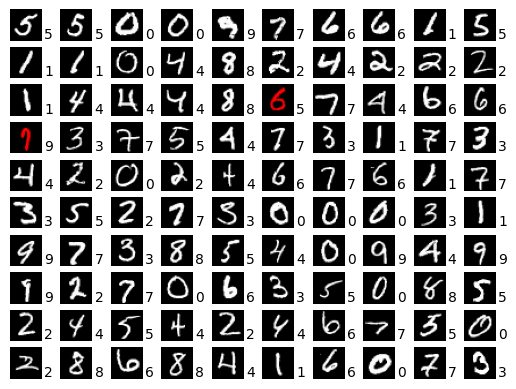

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.212499
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.204485
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.091905
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.101439
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022024
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.031374
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.209606
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.032681
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.050715
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.107837

Test set: Average loss: 0.0909, Accuracy: 9747/10000 (97.47%)



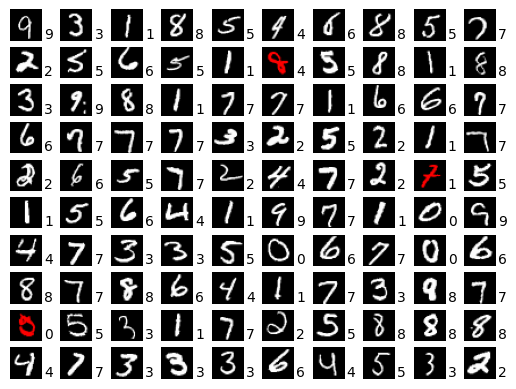

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.125711
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.025773
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.300614
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.042049
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.037294
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.119172
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.099923
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.002911
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.003325
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.029392

Test set: Average loss: 0.0831, Accuracy: 9782/10000 (97.82%)



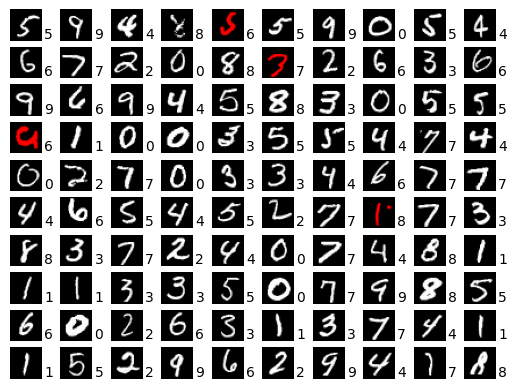

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.004144
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.007697
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.005610
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.002179
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.108191
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.166263
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.004284
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.094040
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.000701
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.026996

Test set: Average loss: 0.0724, Accuracy: 9824/10000 (98.24%)



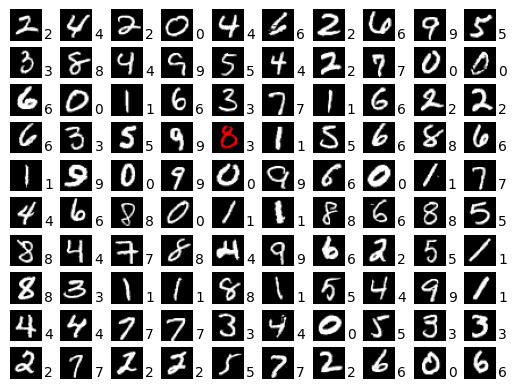

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.020362
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.037871
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.063454
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.076414
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.000774
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.000913
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.001819
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.026958
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.028428
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.006859

Test set: Average loss: 0.0733, Accuracy: 9825/10000 (98.25%)



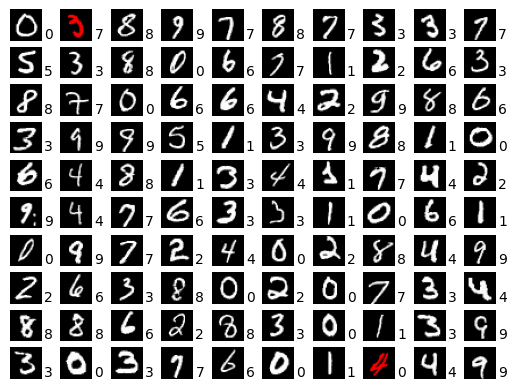

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.000607
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.000218
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.008995
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.000743
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.024836
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.000223
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.001830
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.003186
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.001581
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.006978

Test set: Average loss: 0.0792, Accuracy: 9816/10000 (98.16%)



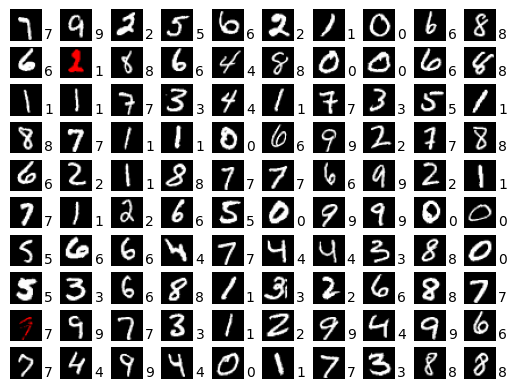

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.001169
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.012354
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.001669
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.005429
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.000564
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.000348
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.002192
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.000244
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.000755
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.000456

Test set: Average loss: 0.0800, Accuracy: 9833/10000 (98.33%)



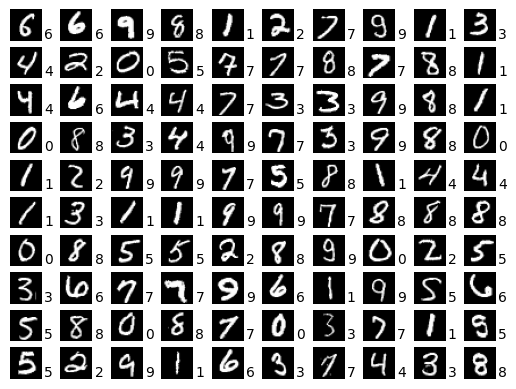

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.019533
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.003206
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.001510
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.000993
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.019680
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.000486
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.000365
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.001984
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.000080
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.000458

Test set: Average loss: 0.0828, Accuracy: 9828/10000 (98.28%)



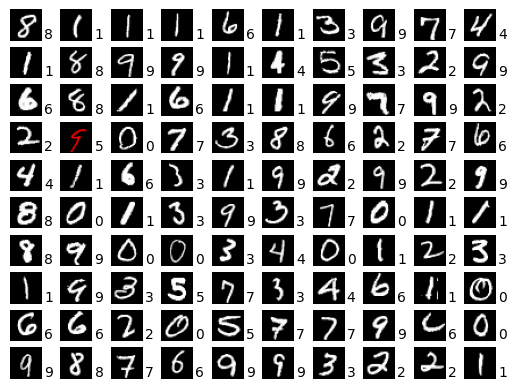

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.000208
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.000053
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.001092
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.000484
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.027093
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.000522
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.000966
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.000351
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.006689
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.001260

Test set: Average loss: 0.0841, Accuracy: 9828/10000 (98.28%)



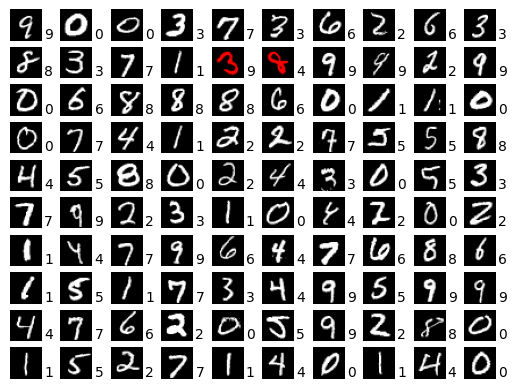

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.005291
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.000471
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.000874
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.000942
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.002101
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.000815
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.112090
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.001416
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.013060
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.000089

Test set: Average loss: 0.0863, Accuracy: 9826/10000 (98.26%)



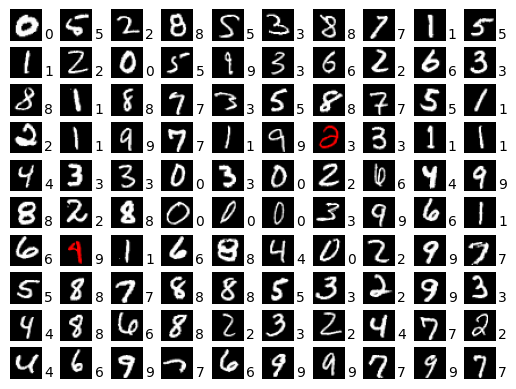

In [12]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = FCNet2()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")